<a href="https://colab.research.google.com/github/DiegoPincheiraIb/EL4106_Assignments/blob/main/Assignment6/Assignment6_EL4106.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuraciones preliminares

## Carga de librerias

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import time
import matplotlib.pyplot as plt


Using TensorFlow backend.


## Parámetros

In [ ]:
batch_size = 128 # Batch Size a utilizar
num_classes = 10 # Cantidad de clases en los datos
Lista_Epocas = [2, 6, 12] # Lista con cantidad de épocas en cada iteración

# Dimensiones de las imágenes que entrarán a la red
img_rows, img_cols = 28, 28

## Conjuntos

In [ ]:
# Se cargan los datos correspondientes a los conjuntos por defecto de Entrenamiento y Validación
(x_train_og, y_train_og), (x_test, y_test) = mnist.load_data()

# Se preprocesan los datos:
if K.image_data_format() == 'channels_first':
    x_train_og = x_train_og.reshape(x_train_og.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_og = x_train_og.reshape(x_train_og.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train_og = x_train_og.astype('float32')
x_test = x_test.astype('float32')
x_train_og /= 255
x_test /= 255 # Imágenes del conjunto de Prueba
print('x_train_og shape:', x_train_og.shape)
print(x_train_og.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Se convierte los vectores que contienen las clases a matrices binarias
y_train_og = keras.utils.to_categorical(y_train_og, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes) # Clases del conjunto de Prueba
print(x_train_og.shape)
print(y_train_og.shape)

11493376/11490434 [==============================] - 1s 0us/step
x_train_og shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
(60000, 28, 28, 1)
(60000, 10)


In [ ]:
# Se separa el conjunto de entrenamiento original en el conjunto definitivo de Entrenamiento y Validación
Pctg_og = 0.75
Pctg = int(x_train_og.shape[0]*Pctg_og)

X_train = x_train_og[:Pctg] # Imágenes del conjunto de Entren.
X_val = x_train_og[Pctg:] # Imágenes del conjunto de Val.

Y_train = y_train_og[:Pctg] # Clases del conjunto de Entren.
Y_val = y_train_og[Pctg:] # Clases del conjunto de Val.

# Se establece un diccionario que contiene los valores de cada conjunto
# (imágenes y clases):

Dicc_Valores = {
    'Train': (X_train, Y_train),
    'Val': (X_val, Y_val),
    'Test': (x_test, y_test)
}

In [ ]:
for key in Dicc_Valores: # Verifico que las dimensiones de los conjuntos sean las adecuadas
  print(Dicc_Valores[key][0].shape)
  print(Dicc_Valores[key][1].shape)

(45000, 28, 28, 1)
(45000, 10)
(15000, 28, 28, 1)
(15000, 10)
(10000, 28, 28, 1)
(10000, 10)


## Funciones

### Gráfico_Curvas

In [ ]:
def Grafico_Curvas(Modelo_Entrenado,Acc_o_Loss, Nombre, Indicador = False):
  plt.plot(Modelo_Entrenado.history[Acc_o_Loss])
  plt.plot(Modelo_Entrenado.history['val_' + Acc_o_Loss])
  plt.title(Acc_o_Loss + ' de ' + Nombre + ': ' + str(len(Modelo_Entrenado.history[Acc_o_Loss])) + ' épocas')
  plt.ylabel(Acc_o_Loss)
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='best')
  plt.xlim([0, len(Modelo_Entrenado.history[Acc_o_Loss])-1])
  if Indicador == True:
    plt.ylim([0, 1])
  plt.show()

### Entrenamiento_Red

In [ ]:
def Entrenamiento_Red(modelo_obj, Dicc_Valores_Obj,Lista_Epocas_Obj, Nombre_Experimento, batch_size_obj):
  for epoca in Lista_Epocas_Obj:
    print('###### ----- Cantidad de épocas:', epoca)
    print(' ')
    t_inicial= time.clock()
    Exp_obj = modelo_obj.fit(Dicc_Valores_Obj['Train'][0], Dicc_Valores_Obj['Train'][1],
              batch_size=batch_size_obj,
              epochs=epoca,
              verbose=1,
              validation_data=(Dicc_Valores_Obj['Val'][0], Dicc_Valores_Obj['Val'][1]))
    t_final = time.clock() - t_inicial
    print('Tiempo de entrenamiento: ', '%0.3f segundos' %t_final)
    print('---------------------------')
    for key in Dicc_Valores_Obj:
      score = modelo_obj.evaluate(Dicc_Valores_Obj[key][0], Dicc_Valores_Obj[key][1], verbose=0)
      print(key + ' Loss:', '%0.4f' %score[0])
      print(key + ' Accuracy :', '%0.4f' %score[1])
      print('---------------------------')

    Grafico_Curvas(Exp_obj,'accuracy', Nombre_Experimento, Indicador = False)
    Grafico_Curvas(Exp_obj,'loss', Nombre_Experimento, Indicador = False)
    print('-----------------------------------------------------------------')
    print('-----------------------------------------------------------------')
    print('-----------------------------------------------------------------')
    print('-----------------------------------------------------------------')

### Grafico_Filtros

In [ ]:
def Grafico_Filtros(modelo, n_filas,n_columnas):
  filters, biases = modelo.layers[0].get_weights()
  # normalize filter values to 0-1 so we can visualize them
  f_min, f_max = filters.min(), filters.max()
  filters = (filters - f_min) / (f_max - f_min)
  ix = 1
  plt.figure(figsize=(13,5))
  for i in range(n_filas):
    for j in range(n_columnas):
      indice = j + (n_columnas*i)
      if indice >= 32:
        break
      f = filters[:, :, :, indice]
      ax = plt.subplot(n_filas,n_columnas, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(f[:, :, 0], cmap='gray',aspect='equal')
      ix += 1
    plt.subplots_adjust(hspace = None)
  plt.show()

# Redes

## Red original

### Modelo de la red

In [ ]:
model_0 = Sequential()
model_0.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_0.add(Conv2D(64, (3, 3), activation='relu'))
model_0.add(MaxPooling2D(pool_size=(2, 2)))
model_0.add(Dropout(0.25))
model_0.add(Flatten())
model_0.add(Dense(128, activation='relu'))
model_0.add(Dropout(0.5))
model_0.add(Dense(num_classes, activation='softmax'))

model_0.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### Entrenamiento y evaluación de la red

###### ----- Cantidad de épocas: 2
 
Train on 45000 samples, validate on 15000 samples
Epoch 1/2
45000/45000 [==============================] - 11s 240us/step - loss: 0.3091 - accuracy: 0.9042 - val_loss: 0.0837 - val_accuracy: 0.9752
Epoch 2/2
45000/45000 [==============================] - 4s 83us/step - loss: 0.1008 - accuracy: 0.9701 - val_loss: 0.0624 - val_accuracy: 0.9813
Tiempo de entrenamiento:  9.695 segundos
---------------------------
Train Loss: 0.0460
Train Accuracy : 0.9858
---------------------------
Val Loss: 0.0624
Val Accuracy : 0.9813
---------------------------
Test Loss: 0.0479
Test Accuracy : 0.9838
---------------------------


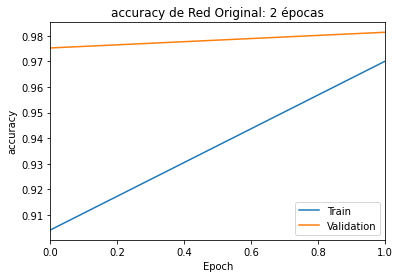

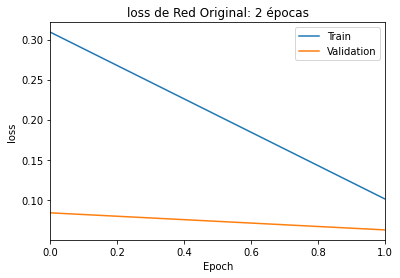

-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
###### ----- Cantidad de épocas: 6
 
Train on 45000 samples, validate on 15000 samples
Epoch 1/6
45000/45000 [==============================] - 4s 84us/step - loss: 0.0732 - accuracy: 0.9781 - val_loss: 0.0501 - val_accuracy: 0.9844
Epoch 2/6
45000/45000 [==============================] - 4s 83us/step - loss: 0.0601 - accuracy: 0.9818 - val_loss: 0.0508 - val_accuracy: 0.9856
Epoch 3/6
45000/45000 [==============================] - 4s 83us/step - loss: 0.0524 - accuracy: 0.9846 - val_loss: 0.0459 - val_accuracy: 0.9875
Epoch 4/6
45000/45000 [==============================] - 4s 83us/step - loss: 0.0447 - accuracy: 0.9861 - val_loss: 0.0433 - val_accuracy: 0.9877
Epoch 5/6
45000/45000 [==============================] - 4s 83us/

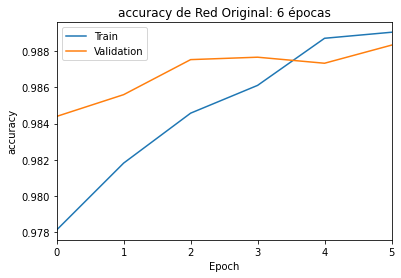

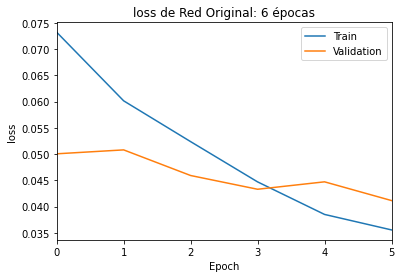

-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
###### ----- Cantidad de épocas: 12
 
Train on 45000 samples, validate on 15000 samples
Epoch 1/12
45000/45000 [==============================] - 4s 84us/step - loss: 0.0311 - accuracy: 0.9903 - val_loss: 0.0430 - val_accuracy: 0.9889
Epoch 2/12
45000/45000 [==============================] - 4s 84us/step - loss: 0.0295 - accuracy: 0.9913 - val_loss: 0.0426 - val_accuracy: 0.9887
Epoch 3/12
45000/45000 [==============================] - 4s 83us/step - loss: 0.0275 - accuracy: 0.9915 - val_loss: 0.0429 - val_accuracy: 0.9883
Epoch 4/12
45000/45000 [==============================] - 4s 83us/step - loss: 0.0250 - accuracy: 0.9917 - val_loss: 0.0432 - val_accuracy: 0.9889
Epoch 5/12
45000/45000 [==============================] - 4s

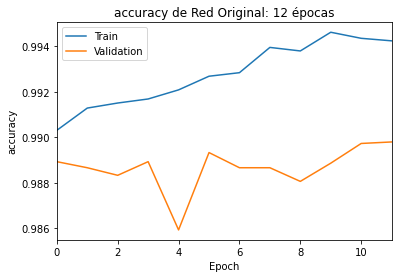

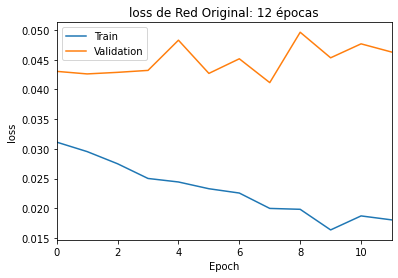

-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------


In [ ]:
Entrenamiento_Red(model_0, Dicc_Valores,Lista_Epocas, 'Red Original', batch_size)

## Red 2: Ausencia de segunda capa convolucional

In [ ]:
model_1 = Sequential()
model_1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

###### ----- Cantidad de épocas: 2
 
Train on 45000 samples, validate on 15000 samples
Epoch 1/2
45000/45000 [==============================] - 2s 50us/step - loss: 0.3949 - accuracy: 0.8796 - val_loss: 0.1281 - val_accuracy: 0.9622
Epoch 2/2
45000/45000 [==============================] - 2s 44us/step - loss: 0.1615 - accuracy: 0.9525 - val_loss: 0.0936 - val_accuracy: 0.9725
Tiempo de entrenamiento:  5.133 segundos
---------------------------
Train Loss: 0.0782
Train Accuracy : 0.9770
---------------------------
Val Loss: 0.0936
Val Accuracy : 0.9725
---------------------------
Test Loss: 0.0807
Test Accuracy : 0.9749
---------------------------


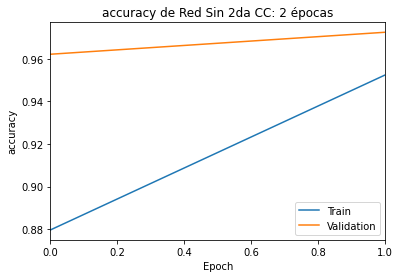

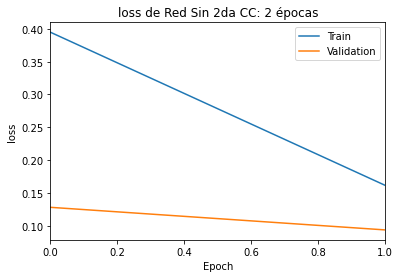

-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
###### ----- Cantidad de épocas: 6
 
Train on 45000 samples, validate on 15000 samples
Epoch 1/6
45000/45000 [==============================] - 2s 46us/step - loss: 0.1208 - accuracy: 0.9638 - val_loss: 0.0792 - val_accuracy: 0.9763
Epoch 2/6
45000/45000 [==============================] - 2s 45us/step - loss: 0.1012 - accuracy: 0.9702 - val_loss: 0.0702 - val_accuracy: 0.9796
Epoch 3/6
45000/45000 [==============================] - 2s 43us/step - loss: 0.0878 - accuracy: 0.9736 - val_loss: 0.0631 - val_accuracy: 0.9813
Epoch 4/6
45000/45000 [==============================] - 2s 44us/step - loss: 0.0777 - accuracy: 0.9758 - val_loss: 0.0597 - val_accuracy: 0.9829
Epoch 5/6
45000/45000 [==============================] - 2s 44us/

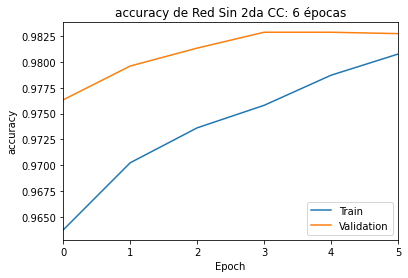

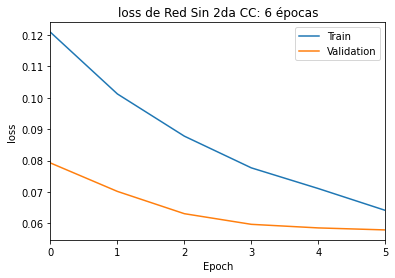

-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
###### ----- Cantidad de épocas: 12
 
Train on 45000 samples, validate on 15000 samples
Epoch 1/12
45000/45000 [==============================] - 2s 46us/step - loss: 0.0593 - accuracy: 0.9825 - val_loss: 0.0542 - val_accuracy: 0.9845
Epoch 2/12
45000/45000 [==============================] - 2s 48us/step - loss: 0.0549 - accuracy: 0.9834 - val_loss: 0.0523 - val_accuracy: 0.9846
Epoch 3/12
45000/45000 [==============================] - 2s 48us/step - loss: 0.0522 - accuracy: 0.9847 - val_loss: 0.0529 - val_accuracy: 0.9845
Epoch 4/12
45000/45000 [==============================] - 2s 47us/step - loss: 0.0500 - accuracy: 0.9846 - val_loss: 0.0527 - val_accuracy: 0.9844
Epoch 5/12
45000/45000 [==============================] - 2s

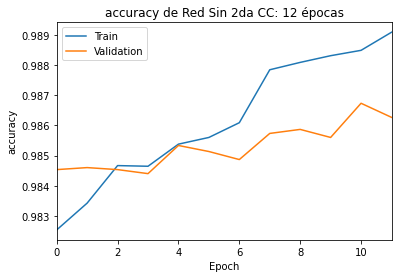

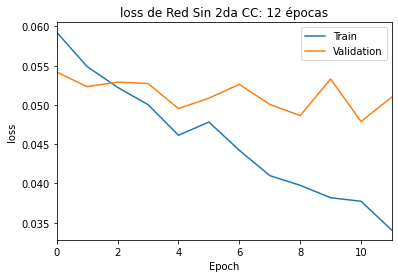

-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------


In [ ]:
Entrenamiento_Red(model_1, Dicc_Valores,Lista_Epocas, 'Red Sin 2da CC', batch_size)

## Red 3: Red sin dropout

In [ ]:
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(num_classes, activation='softmax'))

model_2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

###### ----- Cantidad de épocas: 2
 
Train on 45000 samples, validate on 15000 samples
Epoch 1/2
45000/45000 [==============================] - 4s 82us/step - loss: 0.2340 - accuracy: 0.9279 - val_loss: 0.0800 - val_accuracy: 0.9778
Epoch 2/2
45000/45000 [==============================] - 3s 77us/step - loss: 0.0531 - accuracy: 0.9835 - val_loss: 0.0541 - val_accuracy: 0.9841
Tiempo de entrenamiento:  7.020 segundos
---------------------------
Train Loss: 0.0322
Train Accuracy : 0.9910
---------------------------
Val Loss: 0.0541
Val Accuracy : 0.9841
---------------------------
Test Loss: 0.0430
Test Accuracy : 0.9843
---------------------------


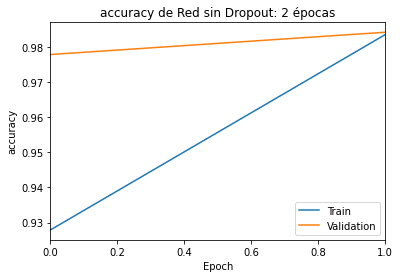

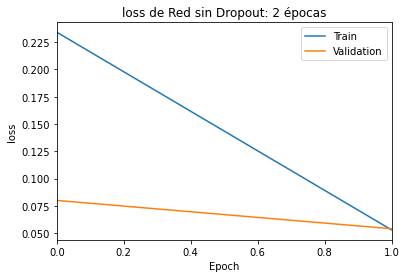

-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
###### ----- Cantidad de épocas: 6
 
Train on 45000 samples, validate on 15000 samples
Epoch 1/6
45000/45000 [==============================] - 4s 78us/step - loss: 0.0326 - accuracy: 0.9897 - val_loss: 0.0492 - val_accuracy: 0.9866
Epoch 2/6
45000/45000 [==============================] - 3s 77us/step - loss: 0.0223 - accuracy: 0.9930 - val_loss: 0.0526 - val_accuracy: 0.9854
Epoch 3/6
45000/45000 [==============================] - 3s 77us/step - loss: 0.0153 - accuracy: 0.9954 - val_loss: 0.0504 - val_accuracy: 0.9873
Epoch 4/6
45000/45000 [==============================] - 4s 78us/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 0.0478 - val_accuracy: 0.9873
Epoch 5/6
45000/45000 [==============================] - 3s 78us/

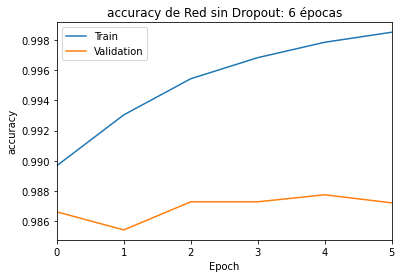

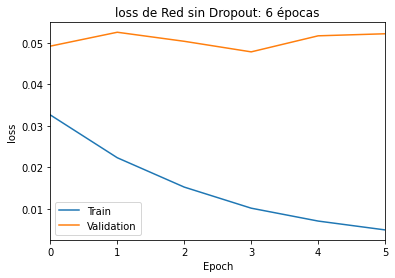

-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
###### ----- Cantidad de épocas: 12
 
Train on 45000 samples, validate on 15000 samples
Epoch 1/12
45000/45000 [==============================] - 4s 78us/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0635 - val_accuracy: 0.9870
Epoch 2/12
45000/45000 [==============================] - 4s 78us/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0605 - val_accuracy: 0.9882
Epoch 3/12
45000/45000 [==============================] - 4s 78us/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0576 - val_accuracy: 0.9890
Epoch 4/12
45000/45000 [==============================] - 4s 78us/step - loss: 8.1026e-04 - accuracy: 0.9998 - val_loss: 0.0610 - val_accuracy: 0.9885
Epoch 5/12
45000/45000 [==============================] 

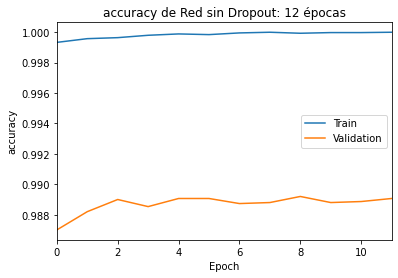

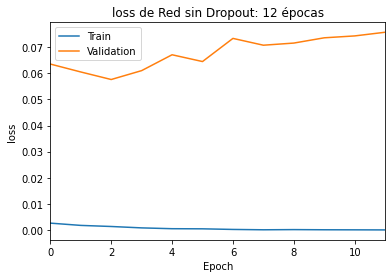

-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------


In [ ]:
Entrenamiento_Red(model_2, Dicc_Valores,Lista_Epocas, 'Red sin Dropout', batch_size)

Revisar: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

## Red con filtro 7x7

### Modelo de la red

In [ ]:
model_3 = Sequential()
model_3.add(Conv2D(32, kernel_size=(7, 7),
                 activation='relu',
                 input_shape=input_shape))
model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))
model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes, activation='softmax'))

model_3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

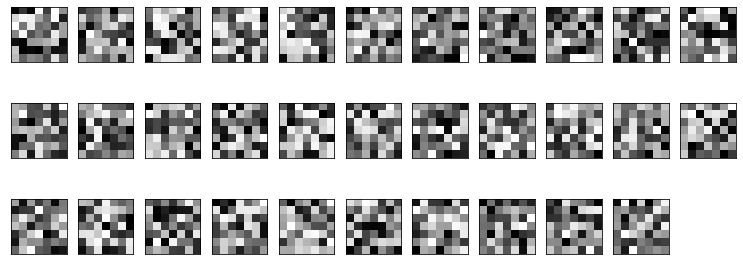

In [ ]:
Grafico_Filtros(model_3,3,11)

###### ----- Cantidad de épocas: 12
 
Train on 45000 samples, validate on 15000 samples
Epoch 1/12
45000/45000 [==============================] - 4s 78us/step - loss: 0.2831 - accuracy: 0.9120 - val_loss: 0.0981 - val_accuracy: 0.9700
Epoch 2/12
45000/45000 [==============================] - 3s 70us/step - loss: 0.0933 - accuracy: 0.9713 - val_loss: 0.0576 - val_accuracy: 0.9820
Epoch 3/12
45000/45000 [==============================] - 3s 69us/step - loss: 0.0665 - accuracy: 0.9799 - val_loss: 0.0461 - val_accuracy: 0.9861
Epoch 4/12
45000/45000 [==============================] - 3s 68us/step - loss: 0.0563 - accuracy: 0.9831 - val_loss: 0.0463 - val_accuracy: 0.9869
Epoch 5/12
45000/45000 [==============================] - 3s 68us/step - loss: 0.0470 - accuracy: 0.9861 - val_loss: 0.0396 - val_accuracy: 0.9879
Epoch 6/12
45000/45000 [==============================] - 3s 68us/step - loss: 0.0436 - accuracy: 0.9869 - val_loss: 0.0438 - val_accuracy: 0.9881
Epoch 7/12
45000/45000 [======

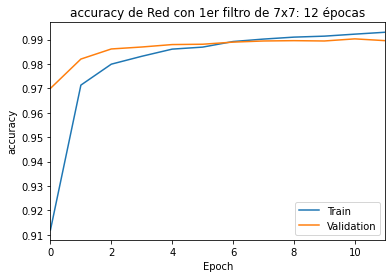

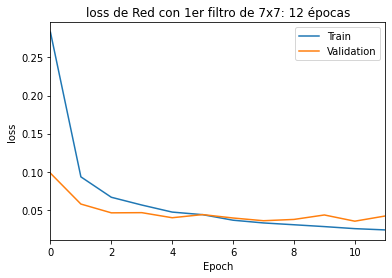

-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------


In [ ]:
Entrenamiento_Red(model_3, Dicc_Valores,[12], 'Red con 1er filtro de 7x7', batch_size)

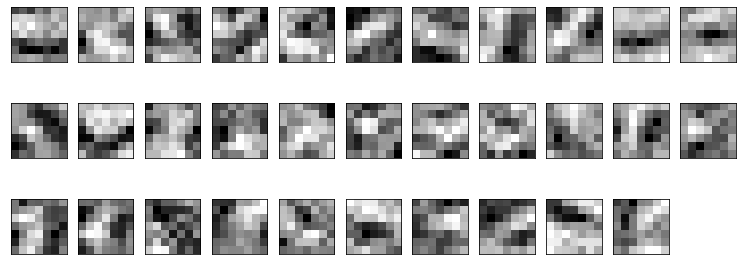

In [ ]:
Grafico_Filtros(model_3,3,11)